In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import seaborn as sns
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
from scipy.stats import uniform, randint

import xgboost as xgb

In [3]:
import problem

In [4]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from sklearn.compose import make_column_transformer

from sklearn.preprocessing import FunctionTransformer,RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor#,HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [5]:
import sklearn
sklearn.__version__

'0.23.2'

# Chargement des données

## Main dataset

In [6]:
pdf_flight = pd.read_csv(
    os.path.join('data', 'train.csv.bz2'),parse_dates=["DateOfDeparture"]
)
pdf_flight.head(2)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734


## Temperatures

In [7]:
pdf_temp = pd.read_csv(
    os.path.join("submissions", "work","temperatures.csv")
)
pdf_temp.head(2)

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185


## Holidays

In [8]:
# From https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020

pdf_holiday = pd.read_csv(
    os.path.join("submissions", "work","usholidays.csv")
)[["Date","Holiday"]]
pdf_holiday["is_holiday"]="yes"
pdf_holiday.head(2)

,Date,Holiday,is_holiday
0,2010-12-31,New Year's Day,yes
1,2011-01-17,"Birthday of Martin Luther King, Jr.",yes


## US airport

In [9]:
# from https://www.kaggle.com/flashgordon/usa-airport-dataset
pdf_airport = pd.read_csv(
    os.path.join("submissions", "work","Airports2.csv"),parse_dates=["Fly_date"]
)
pdf_airport.head(2)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150001


In [10]:
pdf_test=pd.read_csv("https://raw.githubusercontent.com/roberthryniewicz/datasets/master/airline-dataset/flights/flights.csv")
pdf_test.head(2)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


## US GDP

In [11]:
# GDP from https://fred.stlouisfed.org/series/USALORSGPNOSTSAM

In [12]:
pdf_gdp = pd.read_csv(
    os.path.join("submissions", "work","USALORSGPNOSTSAM.csv"),parse_dates=["DATE"]
)
pdf_gdp.head(2)

,DATE,USALORSGPNOSTSAM
0,1960-01-01,100.994363
1,1960-02-01,101.004509


## School off

In [13]:
# school_off
pdf_school = pd.read_csv(
    os.path.join("submissions", "work","school_off.csv"),parse_dates=["Date"]
)
pdf_school["school_off"]=1
pdf_school.head(2)

,Date,school_off
0,2011-05-30,1
1,2011-05-31,1


## Airline equipment

In [14]:
# from https://openflights.org/data.html
# list airline equipments
pdf_routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                         names=[
                            "Airline",
                            "Airline ID",
                            "Source airport",
                            "Source airport ID",
                            "Destination airport",
                            "Destination airport ID",
                            "Codeshare",
                            "Stops",
                            "Equipment",
                         ])
print(pdf_routes.shape)
pdf_routes.head(2)

(67663, 9)


,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2


In [15]:
pdf_routes.Equipment.unique()

array(['CR2', 'A81', 'AN4', ..., '737 777 320', '330 747 777 737',
       'BE1 BEH'], dtype=object)

# Analyses & transformation

In [16]:
pdf_flight.shape

(8902, 6)

In [17]:
pdf_flight.isnull().sum()

DateOfDeparture     0
Departure           0
Arrival             0
WeeksToDeparture    0
log_PAX             0
std_wtd             0
dtype: int64

<AxesSubplot:xlabel='DateOfDeparture', ylabel='log_PAX'>

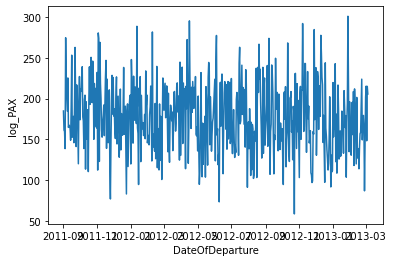

In [18]:
data = pdf_flight.groupby("DateOfDeparture").agg({"log_PAX":np.sum}).reset_index()
data.loc[:, "DateOfDeparture"] = pd.to_datetime(data['DateOfDeparture'])

sns.lineplot(
    x="DateOfDeparture",
    y="log_PAX",
    data=data)

In [19]:
# 'Rain-Thunderstorm-Tornado' fait planter les OHE -> rare ?
# Question : comment forcer les catégories des OHE
pdf_temp.Events.value_counts()

Rain                          2171
Rain-Thunderstorm              655
Fog                            540
Snow                           324
Fog-Rain                       199
Rain-Snow                      140
Fog-Rain-Thunderstorm           76
Thunderstorm                    65
Fog-Snow                        63
Fog-Rain-Snow                   46
Rain-Hail-Thunderstorm           6
Fog-Rain-Hail-Thunderstorm       3
Fog-Rain-Snow-Thunderstorm       3
Rain-Snow-Thunderstorm           3
Rain-Thunderstorm-Tornado        1
Name: Events, dtype: int64

In [20]:
pdf_temp.Events = (pdf_temp.Events
                   .replace({
                       "Fog-Rain-Hail-Thunderstorm":"Fog-Rain",
                       "Fog-Rain-Snow-Thunderstorm":"Fog-Rain-Snow",
                       "Rain-Thunderstorm-Tornado":"Rain-Thunderstorm",
                       "Rain-Snow-Thunderstorm":"Rain-Snow",
                       "Rain-Hail-Thunderstorm":"Rain-Thunderstorm",
                   }))
pdf_temp.Events.value_counts()

Rain                     2171
Rain-Thunderstorm         662
Fog                       540
Snow                      324
Fog-Rain                  202
Rain-Snow                 143
Fog-Rain-Thunderstorm      76
Thunderstorm               65
Fog-Snow                   63
Fog-Rain-Snow              49
Name: Events, dtype: int64

In [21]:
# Precipitationmm comprend 1 'T'
pdf_temp.Precipitationmm = pdf_temp.Precipitationmm.replace("T",0.0).astype(float)

# Feature creation

## Family Day

In [22]:
pdf_holidays = pd.DataFrame(calendar().holidays(start='2011-01-01', end='2013-12-31'),columns=["Date"])
pdf_holidays["holiday"]=1
pdf_familyday = pd.DataFrame(
    data=pd.date_range(datetime.datetime(2011, 1, 1), datetime.datetime(2013, 12, 31)),
    columns=["Date"]
)
pdf_familyday = pd.merge(pdf_familyday,pdf_holidays,how="left",on="Date")
pdf_familyday=pdf_familyday.fillna(0)

pdf_familyday["we"]=pdf_familyday.Date.apply(lambda d: 0.6 if d.weekday()==0 else 0.4 if d.weekday()==6 else 0)

pdf_familyday["familyday_sum"] = pdf_familyday["holiday"] + pdf_familyday["we"]

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
pdf_familyday["familyday_score"] = (
    pdf_familyday["familyday_sum"].rolling(window=indexer).sum() +
    pdf_familyday["familyday_sum"].rolling(window=2).sum()
)

print(pdf_familyday.holiday.value_counts())
pdf_familyday.head(20)

0.0    1067
1.0      29
Name: holiday, dtype: int64


,Date,holiday,we,familyday_sum,familyday_score
0,2011-01-01,0.0,0.0,0.0,NaN
1,2011-01-02,0.0,0.4,0.4,1.4
2,2011-01-03,0.0,0.6,0.6,1.6
3,2011-01-04,0.0,0.0,0.0,0.6
4,2011-01-05,0.0,0.0,0.0,0.0
5,2011-01-06,0.0,0.0,0.0,0.0
6,2011-01-07,0.0,0.0,0.0,0.0
7,2011-01-08,0.0,0.0,0.0,0.4
8,2011-01-09,0.0,0.4,0.4,1.4
9,2011-01-10,0.0,0.6,0.6,1.6


## Fréquentation / j / airport

In [23]:
# jours non représentatifs .. snif
len(pdf_airport.Fly_date.unique())

240

In [24]:
pdf_airport["doy"] = pdf_airport.Fly_date.dt.dayofyear

In [25]:
pdf_flight.columns

Index(['DateOfDeparture', 'Departure', 'Arrival', 'WeeksToDeparture',
       'log_PAX', 'std_wtd'],
      dtype='object')

In [26]:
# OK
len(pdf_flight.DateOfDeparture.dt.dayofyear.unique())

366

In [27]:
pdf_flight["doy"] = pdf_flight.DateOfDeparture.dt.dayofyear

In [28]:
pdf_frequentation = pdf_flight.groupby(["doy"]).agg({"log_PAX":np.mean}).rename(columns={"log_PAX":"mean_frequentation"}).reset_index()

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
pdf_frequentation["agg_frequentation"] = (
    pdf_frequentation["mean_frequentation"].rolling(window=indexer).sum() +
    pdf_frequentation["mean_frequentation"].rolling(window=4).sum()
)

pdf_frequentation=pdf_frequentation.fillna(method="bfill") # fill begin of year
pdf_frequentation=pdf_frequentation.fillna(method="ffill") # fill end of year
pdf_frequentation.head(5)

,doy,mean_frequentation,agg_frequentation
0,1,9.694309,83.145257
1,2,10.832029,83.145257
2,3,10.648499,83.145257
3,4,10.323395,83.145257
4,5,10.212460,84.185555


In [29]:
pdf_frequentation.tail(5)

,doy,mean_frequentation,agg_frequentation
361,362,10.183050,78.996179
362,363,10.033183,78.222517
363,364,9.730633,78.222517
364,365,9.524674,78.222517
365,366,8.595911,78.222517


<AxesSubplot:xlabel='doy', ylabel='agg_frequentation'>

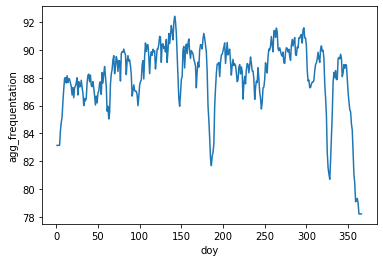

In [30]:
sns.lineplot(
    x="doy",
    y="agg_frequentation",
    data=pdf_frequentation)

## Détection des jointures

In [31]:
a = pdf_flight.Arrival.unique()
len(a),a

(20,
 array(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
        'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA',
        'SEA', 'IAH'], dtype=object))

- ATL : Hartsfield–Jackson Atlanta International Airport - Georgia
- DFW : Dallas/Fort Worth International Airport - Texas
- DEN : Denver International Airport - Colorado

In [32]:
# L'aéroport de DENVERS est absent de pdf_airport
set(a) - set(pdf_airport.Origin_airport.unique())

{'DEN'}

In [33]:
(
    pdf_flight.DateOfDeparture.min(),
    pdf_flight.DateOfDeparture.max(),
)

(Timestamp('2011-09-01 00:00:00'), Timestamp('2013-03-05 00:00:00'))

In [34]:
a = pdf_temp.AirPort.unique()
len(a),a

(20,
 array(['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'JFK', 'SFO', 'CLT', 'LAS',
        'PHX', 'IAH', 'MIA', 'MCO', 'EWR', 'SEA', 'MSP', 'DTW', 'PHL',
        'BOS', 'LGA'], dtype=object))

In [35]:
(
    pdf_temp.Date.min(),
    pdf_temp.Date.max(),
)

('2011-09-01', '2013-03-05')

# Constitution du fichier external_data

In [36]:
pdf_temp.shape,pdf_holiday.shape

((11040, 24), (485, 3))

In [37]:
pdf_temp.Date.describe(),pdf_holiday.Date.describe()

(count          11040
 unique           552
 top       2013-02-02
 freq              20
 Name: Date, dtype: object,
 count            485
 unique           484
 top       1989-11-11
 freq               2
 Name: Date, dtype: object)

In [38]:
pdf_temp.Events.unique()

array([nan, 'Rain', 'Rain-Thunderstorm', 'Fog', 'Fog-Rain-Thunderstorm',
       'Rain-Snow', 'Snow', 'Fog-Rain', 'Thunderstorm', 'Fog-Snow',
       'Fog-Rain-Snow'], dtype=object)

In [39]:
#pdf_joined = pdf_temp.set_index("Date").join(pdf_holiday.set_index("Date")).reset_index()
pdf_joined = pdf_temp.set_index("Date").join(pdf_familyday.set_index("Date")).reset_index()
print(pdf_joined.shape)
pdf_joined.head()

(11040, 28)


,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.0,3,NaN,129,0.0,0.0,0.0,0.0
1,2011-09-01,ORD,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0.0,1,NaN,197,0.0,0.0,0.0,0.0
2,2011-09-01,LAX,21,18,15,14,14,13,90,76,61,1012,1011,1009,16,11,4,23,13,NaN,0.0,5,Fog,265,0.0,0.0,0.0,0.0
3,2011-09-01,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.0,1,NaN,157,0.0,0.0,0.0,0.0
4,2011-09-01,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.0,5,NaN,205,0.0,0.0,0.0,0.0


In [40]:
pdf_joined.columns

Index(['Date', 'AirPort', 'Max TemperatureC', 'Mean TemperatureC',
       'Min TemperatureC', 'Dew PointC', 'MeanDew PointC', 'Min DewpointC',
       'Max Humidity', 'Mean Humidity', 'Min Humidity',
       'Max Sea Level PressurehPa', 'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa', 'Max VisibilityKm', 'Mean VisibilityKm',
       'Min VisibilitykM', 'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'holiday', 'we', 'familyday_sum', 'familyday_score'],
      dtype='object')

In [41]:
pdf_airport.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long', 'doy'],
      dtype='object')

In [42]:
pdf_airport.Fly_date.min(),pdf_airport.Fly_date.max()

(Timestamp('1990-01-01 00:00:00'), Timestamp('2009-12-01 00:00:00'))

In [43]:
pdf_airport_agg = (pdf_airport
 .groupby("Origin_airport")
 .agg({"Origin_population":np.max,
       "Org_airport_lat":np.mean,
       "Org_airport_long":np.mean
 }).reset_index().rename(columns={
     "Origin_airport":"AirPort",
     "Origin_population":"population",
     "Org_airport_lat":"lat",
     "Org_airport_long":"long"
 })
)
pdf_airport_agg.head()

,AirPort,population,lat,long
0,1B1,61618,NaN,NaN
1,ABE,816012,40.652100,-75.440804
2,ABI,160108,32.411301,-99.681900
3,ABQ,857903,35.040199,-106.609001
4,ABR,40164,45.449100,-98.421799


In [44]:
# Ajout manuel de Denvers
pdf_airport_man = pd.DataFrame([["DEN",716492,39.7351,-104.9847]],columns=["AirPort","population","lat","long"])
pd.concat([pdf_airport_man,pdf_airport_agg])

,AirPort,population,lat,long
0,DEN,716492,39.735100,-104.984700
0,1B1,61618,NaN,NaN
1,ABE,816012,40.652100,-75.440804
2,ABI,160108,32.411301,-99.681900
3,ABQ,857903,35.040199,-106.609001
...,...,...,...,...
678,YKM,239054,46.568199,-120.543999
679,YKN,21710,NaN,NaN
680,YNG,615945,41.260700,-80.679100
681,YUM,196972,32.656601,-114.606003


In [45]:
pdf_joined2 = pdf_joined.set_index("AirPort").join(
    pd.concat([pdf_airport_man,pdf_airport_agg]).set_index("AirPort")
).reset_index()
pdf_joined2.head()

,AirPort,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,lat,long
0,ATL,2011-09-01,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.0,3,NaN,129,0.0,0.0,0.0,0.0,5475213,33.6367,-84.428101
1,ATL,2011-09-02,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.0,2,NaN,185,0.0,0.0,0.0,0.0,5475213,33.6367,-84.428101
2,ATL,2011-09-03,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.0,4,NaN,147,0.0,0.0,0.0,0.4,5475213,33.6367,-84.428101
3,ATL,2011-09-04,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.1,6,Rain,139,0.0,0.4,0.4,2.4,5475213,33.6367,-84.428101
4,ATL,2011-09-05,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.0,8,Rain-Thunderstorm,149,1.0,0.6,1.6,3.6,5475213,33.6367,-84.428101


In [46]:
pdf_joined2.shape

(11040, 31)

## Append Frequentation

In [47]:
pdf_joined2 ["doy"] = pdf_joined2.Date.dt.dayofyear

pdf_joined3 = pdf_joined2.set_index("doy").join(
    pdf_frequentation.set_index("doy")
).reset_index()
pdf_joined3.head()


,doy,AirPort,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,lat,long,mean_frequentation,agg_frequentation
0,1,ATL,2012-01-01,18,12,6,13,7,-2,89,63,37,1022,1020,1017,16,16,11,37,17,47.0,0.00,4,NaN,257,0.0,0.4,0.4,2.4,5475213,33.636700,-84.428101,9.694309,83.145257
1,1,ATL,2013-01-01,12,10,8,11,9,2,100,81,61,1020,1017,1014,16,5,0,21,6,24.0,25.91,8,Rain,105,1.0,0.0,1.0,2.6,5475213,33.636700,-84.428101,9.694309,83.145257
2,1,BOS,2012-01-01,11,8,4,7,4,2,86,73,59,1018,1012,1004,16,16,14,32,15,40.0,0.25,4,Rain,224,0.0,0.4,0.4,2.4,9177360,42.364300,-71.005203,9.694309,83.145257
3,1,BOS,2013-01-01,3,-2,-7,-4,-9,-16,64,53,41,1013,1009,1007,16,16,16,45,23,60.0,0.00,5,NaN,278,1.0,0.0,1.0,2.6,9177360,42.364300,-71.005203,9.694309,83.145257
4,1,CLT,2012-01-01,19,11,2,12,5,-4,85,60,35,1021,1017,1013,16,16,14,39,14,52.0,0.00,3,NaN,198,0.0,0.4,0.4,2.4,1745524,35.214001,-80.943100,9.694309,83.145257


## Append GDP

In [48]:
pdf_joined3["DateM"] = pdf_joined3.Date.astype('datetime64[M]')
pdf_joined4 = pdf_joined3.set_index("DateM").join(
    pdf_gdp.set_index("DATE")
).reset_index().drop(columns=["index"])
print(pdf_joined4.shape)
pdf_joined4.head(5)

(11040, 35)


,doy,AirPort,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,lat,long,mean_frequentation,agg_frequentation,USALORSGPNOSTSAM
0,244,ATL,2011-09-01,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.0,3,NaN,129,0.0,0.0,0.0,0.0,5475213,33.636700,-84.428101,11.297574,86.94801,99.652324
1,244,BOS,2011-09-01,22,19,17,16,14,12,90,72,53,1024,1023,1021,16,16,14,23,11,26.0,0.0,4,NaN,67,0.0,0.0,0.0,0.0,9177360,42.364300,-71.005203,11.297574,86.94801,99.652324
2,244,CLT,2011-09-01,33,26,17,19,18,16,93,66,38,1022,1020,1017,16,16,11,21,5,24.0,0.0,2,NaN,315,0.0,0.0,0.0,0.0,1745524,35.214001,-80.943100,11.297574,86.94801,99.652324
3,244,DEN,2011-09-01,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.0,5,NaN,205,0.0,0.0,0.0,0.0,716492,39.735100,-104.984700,11.297574,86.94801,99.652324
4,244,DFW,2011-09-01,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.0,1,NaN,157,0.0,0.0,0.0,0.0,12895230,32.896801,-97.038002,11.297574,86.94801,99.652324


## Append school off

In [49]:
pdf_joined5 = pdf_joined4.set_index("Date").join(
    pdf_school.set_index("Date")
).reset_index()
pdf_joined5.school_off = pdf_joined5.school_off.fillna(0)
print(pdf_joined5.shape)
pdf_joined5.head(5)

(11040, 36)


,Date,doy,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,lat,long,mean_frequentation,agg_frequentation,USALORSGPNOSTSAM,school_off
0,2011-09-01,244,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.0,3,NaN,129,0.0,0.0,0.0,0.0,5475213,33.636700,-84.428101,11.297574,86.94801,99.652324,0.0
1,2011-09-01,244,BOS,22,19,17,16,14,12,90,72,53,1024,1023,1021,16,16,14,23,11,26.0,0.0,4,NaN,67,0.0,0.0,0.0,0.0,9177360,42.364300,-71.005203,11.297574,86.94801,99.652324,0.0
2,2011-09-01,244,CLT,33,26,17,19,18,16,93,66,38,1022,1020,1017,16,16,11,21,5,24.0,0.0,2,NaN,315,0.0,0.0,0.0,0.0,1745524,35.214001,-80.943100,11.297574,86.94801,99.652324,0.0
3,2011-09-01,244,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.0,5,NaN,205,0.0,0.0,0.0,0.0,716492,39.735100,-104.984700,11.297574,86.94801,99.652324,0.0
4,2011-09-01,244,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.0,1,NaN,157,0.0,0.0,0.0,0.0,12895230,32.896801,-97.038002,11.297574,86.94801,99.652324,0.0


## Append airline equipment

In [50]:
a = pd.DataFrame([["titi tata titi","A"]],columns=["e","i"])
b = a["e"].str.split().explode()
a.drop(columns=["e"]).join(b)

,i,e
0,A,titi
0,A,tata
0,A,titi


In [51]:
pdf_routes_exploded = pdf_routes.drop(columns=["Equipment"]).join(pdf_routes.Equipment.str.split().explode())
pdf_routes_exploded.shape

(93249, 9)

In [52]:
pdf_routes_exploded.head(2)

,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2


In [53]:
pdf_equipment = (pdf_routes_exploded
 .groupby(["Source airport"])
 .agg({"Equipment":"count"})
 .reset_index()
 .sort_values("Equipment",ascending=False)
 .rename(columns={
     "Source airport":"AirPort",
 })
)
pdf_equipment.head(5)

,AirPort,Equipment
165,ATL,1754
2117,ORD,1011
1616,LHR,904
884,FRA,867
461,CDG,836


In [54]:
pdf_joined6 = pdf_joined5.set_index("AirPort").join(
    pdf_equipment.set_index("AirPort")
).reset_index()
pdf_joined6.Equipment = pdf_joined6.Equipment.fillna(0)
print(pdf_joined6.shape)
pdf_joined6.head(5)

(11040, 37)


,AirPort,Date,doy,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,lat,long,mean_frequentation,agg_frequentation,USALORSGPNOSTSAM,school_off,Equipment
0,ATL,2011-09-01,244,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.0,3,NaN,129,0.0,0.0,0.0,0.0,5475213,33.6367,-84.428101,11.297574,86.948010,99.652324,0.0,1754
1,ATL,2011-09-02,245,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.0,2,NaN,185,0.0,0.0,0.0,0.0,5475213,33.6367,-84.428101,10.758851,86.542683,99.652324,0.0,1754
2,ATL,2011-09-03,246,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.0,4,NaN,147,0.0,0.0,0.0,0.4,5475213,33.6367,-84.428101,9.802466,85.759057,99.652324,0.0,1754
3,ATL,2011-09-04,247,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.1,6,Rain,139,0.0,0.4,0.4,2.4,5475213,33.6367,-84.428101,10.333866,86.246392,99.652324,0.0,1754
4,ATL,2011-09-05,248,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.0,8,Rain-Thunderstorm,149,1.0,0.6,1.6,3.6,5475213,33.6367,-84.428101,11.196749,87.271742,99.652324,0.0,1754


## Save external file

In [55]:
filepath = './submissions/work/external_data.csv'
(pdf_joined6
 .to_csv(filepath, index=False)
)

In [56]:
pd.read_csv(filepath, parse_dates=["Date"]).set_index("Date").reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11040 entries, 0 to 11039
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        11040 non-null  datetime64[ns]
 1   AirPort                     11040 non-null  object        
 2   doy                         11040 non-null  int64         
 3   Max TemperatureC            11040 non-null  int64         
 4   Mean TemperatureC           11040 non-null  int64         
 5   Min TemperatureC            11040 non-null  int64         
 6   Dew PointC                  11040 non-null  int64         
 7   MeanDew PointC              11040 non-null  int64         
 8   Min DewpointC               11040 non-null  int64         
 9   Max Humidity                11040 non-null  int64         
 10  Mean Humidity               11040 non-null  int64         
 11  Min Humidity                11040 non-null  int64     

# Chargement des datasets

In [57]:
X, y = problem.get_train_data()
X.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [58]:
def _merge_external_data(X):
    # Make sure that DateOfDeparture is of dtype datetime
    X = X.copy()  # modify a copy of X
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    
    # Load external file
    
    #filepath = os.path.join(
    #    os.path.dirname(__file__), '/external_data.csv'
    #)
    filepath = './submissions/work/external_data.csv'
    pdf_ext = pd.read_csv(filepath, parse_dates=["Date"])

    df = pd.merge(
        X, pdf_ext.rename(columns={"Date":"DateOfDeparture", "AirPort":"Departure"}),
        how='left', on=['DateOfDeparture', 'Departure'], sort=False, suffixes=(None,"_departure")
    )
    df = pd.merge(
        df, pdf_ext.rename(columns={"Date":"DateOfDeparture", "AirPort":"Arrival"}),
        how='left', on=['DateOfDeparture', 'Arrival'], sort=False, suffixes=(None,"_arrival")
    )
    
    
    def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
        """
        slightly modified version: of http://stackoverflow.com/a/29546836/2901002

        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees or in radians)

        All (lat, lon) coordinates must have numeric dtypes and be of equal length.

        """
        if to_radians:
            lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

        a = np.sin((lat2-lat1)/2.0)**2 + \
            np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

        return earth_radius * 2 * np.arcsin(np.sqrt(a))


    df['dist'] = haversine(df.lat, df.long,df.lat_arrival, df.long_arrival)
    df=df.drop(["lat","long","lat_arrival","long_arrival",],axis=1)
    
    return df
     
test = _merge_external_data(X)
print(X.shape,test.shape)
test.head()

(8902, 5) (8902, 72)


,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,doy,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,mean_frequentation,agg_frequentation,USALORSGPNOSTSAM,school_off,Equipment,doy_arrival,Max TemperatureC_arrival,Mean TemperatureC_arrival,Min TemperatureC_arrival,Dew PointC_arrival,MeanDew PointC_arrival,Min DewpointC_arrival,Max Humidity_arrival,Mean Humidity_arrival,Min Humidity_arrival,Max Sea Level PressurehPa_arrival,Mean Sea Level PressurehPa_arrival,Min Sea Level PressurehPa_arrival,Max VisibilityKm_arrival,Mean VisibilityKm_arrival,Min VisibilitykM_arrival,Max Wind SpeedKm/h_arrival,Mean Wind SpeedKm/h_arrival,Max Gust SpeedKm/h_arrival,Precipitationmm_arrival,CloudCover_arrival,Events_arrival,WindDirDegrees_arrival,holiday_arrival,we_arrival,familyday_sum_arrival,familyday_score_arrival,population_arrival,mean_frequentation_arrival,agg_frequentation_arrival,USALORSGPNOSTSAM_arrival,school_off_arrival,Equipment_arrival,dist
0,2012-06-19,ORD,DFW,12.875000,9.812647,171,35,31,26,20,18,17,62,51,39,1014,1012,1009,16,16,16,37,25,56.0,0.0,1,NaN,208,0.0,0.0,0.0,0.6,19161134,11.037536,88.767033,100.130994,1.0,1011,171,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,60.0,0.0,5,NaN,161,0.0,0.0,0.0,0.6,12895230,11.037536,88.767033,100.130994,1.0,828,1290.645246
1,2012-09-10,LAS,DEN,14.285714,9.466734,254,36,32,27,16,13,10,51,36,21,1011,1009,1005,16,15,11,32,18,50.0,0.0,5,NaN,187,0.0,0.6,0.6,1.6,1902834,11.276661,89.524983,99.906538,0.0,417,254,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,42.0,0.0,3,NaN,207,0.0,0.6,0.6,1.6,716492,11.276661,89.524983,99.906538,0.0,631,979.440700
2,2012-10-05,DEN,LAX,10.863636,9.035883,279,6,2,-1,0,-2,-4,92,76,60,1027,1023,1020,16,9,1,27,15,32.0,0.0,7,Rain-Snow,357,0.0,0.0,0.0,0.0,716492,11.684109,90.047113,99.848384,0.0,631,279,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,29.0,0.0,5,Fog,266,0.0,0.0,0.0,0.0,25749594,11.684109,90.047113,99.848384,0.0,747,1355.082614
3,2011-10-09,ATL,ORD,11.480000,7.990202,282,22,19,16,12,10,6,67,56,44,1026,1024,1021,16,16,16,37,26,45.0,0.0,8,NaN,70,0.0,0.4,0.4,2.4,5475213,11.257361,90.341944,99.765070,0.0,1754,282,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,16,23,6,29.0,0.0,1,NaN,93,0.0,0.4,0.4,2.4,19161134,11.257361,90.341944,99.765070,0.0,1011,976.327839
4,2012-02-21,DEN,SFO,11.450000,9.517159,52,8,2,-4,-6,-9,-13,46,39,31,1012,1008,1004,16,16,16,61,30,77.0,0.0,5,NaN,270,0.0,0.0,0.0,1.6,716492,11.345710,87.594907,100.177976,1.0,631,52,16,12,8,10,8,7,93,79,64,1027,1025,1024,16,12,3,24,8,29.0,0.0,7,NaN,300,0.0,0.0,0.0,1.6,8635706,11.345710,87.594907,100.177976,1.0,431,1525.344638


In [59]:
X.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [60]:
def _encode_dates(X):
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['DateOfDeparture'].dt.year
    X.loc[:, 'month'] = X['DateOfDeparture'].dt.month
    X.loc[:, 'day'] = X['DateOfDeparture'].dt.day
    X.loc[:, 'weekday'] = X['DateOfDeparture'].dt.weekday
    X.loc[:, 'week'] = X['DateOfDeparture'].dt.isocalendar().week
    #X.loc[:, 'n_days'] = X['DateOfDeparture'].apply(
    #    lambda date: (date - pd.to_datetime("1970-01-01")).days
    #)
    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["DateOfDeparture"])
_encode_dates(_merge_external_data(X)).head()

,Departure,Arrival,WeeksToDeparture,std_wtd,doy,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,holiday,we,familyday_sum,familyday_score,population,mean_frequentation,agg_frequentation,USALORSGPNOSTSAM,school_off,Equipment,doy_arrival,Max TemperatureC_arrival,Mean TemperatureC_arrival,Min TemperatureC_arrival,Dew PointC_arrival,MeanDew PointC_arrival,Min DewpointC_arrival,Max Humidity_arrival,Mean Humidity_arrival,Min Humidity_arrival,Max Sea Level PressurehPa_arrival,Mean Sea Level PressurehPa_arrival,Min Sea Level PressurehPa_arrival,Max VisibilityKm_arrival,Mean VisibilityKm_arrival,Min VisibilitykM_arrival,Max Wind SpeedKm/h_arrival,Mean Wind SpeedKm/h_arrival,Max Gust SpeedKm/h_arrival,Precipitationmm_arrival,CloudCover_arrival,Events_arrival,WindDirDegrees_arrival,holiday_arrival,we_arrival,familyday_sum_arrival,familyday_score_arrival,population_arrival,mean_frequentation_arrival,agg_frequentation_arrival,USALORSGPNOSTSAM_arrival,school_off_arrival,Equipment_arrival,dist,year,month,day,weekday,week
0,ORD,DFW,12.875000,9.812647,171,35,31,26,20,18,17,62,51,39,1014,1012,1009,16,16,16,37,25,56.0,0.0,1,NaN,208,0.0,0.0,0.0,0.6,19161134,11.037536,88.767033,100.130994,1.0,1011,171,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,60.0,0.0,5,NaN,161,0.0,0.0,0.0,0.6,12895230,11.037536,88.767033,100.130994,1.0,828,1290.645246,2012,6,19,1,25
1,LAS,DEN,14.285714,9.466734,254,36,32,27,16,13,10,51,36,21,1011,1009,1005,16,15,11,32,18,50.0,0.0,5,NaN,187,0.0,0.6,0.6,1.6,1902834,11.276661,89.524983,99.906538,0.0,417,254,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,42.0,0.0,3,NaN,207,0.0,0.6,0.6,1.6,716492,11.276661,89.524983,99.906538,0.0,631,979.440700,2012,9,10,0,37
2,DEN,LAX,10.863636,9.035883,279,6,2,-1,0,-2,-4,92,76,60,1027,1023,1020,16,9,1,27,15,32.0,0.0,7,Rain-Snow,357,0.0,0.0,0.0,0.0,716492,11.684109,90.047113,99.848384,0.0,631,279,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,29.0,0.0,5,Fog,266,0.0,0.0,0.0,0.0,25749594,11.684109,90.047113,99.848384,0.0,747,1355.082614,2012,10,5,4,40
3,ATL,ORD,11.480000,7.990202,282,22,19,16,12,10,6,67,56,44,1026,1024,1021,16,16,16,37,26,45.0,0.0,8,NaN,70,0.0,0.4,0.4,2.4,5475213,11.257361,90.341944,99.765070,0.0,1754,282,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,16,23,6,29.0,0.0,1,NaN,93,0.0,0.4,0.4,2.4,19161134,11.257361,90.341944,99.765070,0.0,1011,976.327839,2011,10,9,6,40
4,DEN,SFO,11.450000,9.517159,52,8,2,-4,-6,-9,-13,46,39,31,1012,1008,1004,16,16,16,61,30,77.0,0.0,5,NaN,270,0.0,0.0,0.0,1.6,716492,11.345710,87.594907,100.177976,1.0,631,52,16,12,8,10,8,7,93,79,64,1027,1025,1024,16,12,3,24,8,29.0,0.0,7,NaN,300,0.0,0.0,0.0,1.6,8635706,11.345710,87.594907,100.177976,1.0,431,1525.344638,2012,2,21,1,8


In [61]:
test = _merge_external_data(X)
cat_cols = []
for c in test.columns:
    if test[c].dtype==object:
        cat_cols.append(c)
    #print(c,test[c].dtype)
cat_cols

['Departure', 'Arrival', 'Events', 'Events_arrival']

In [62]:
date_cols = ["DateOfDeparture"]
cat_cols = ['Departure', 'Arrival', 'Events', 'Events_arrival']
num_col = list(set(_merge_external_data(X).columns) - set(cat_cols) - set(date_cols))
num_col

['Min Humidity',
 'agg_frequentation_arrival',
 'USALORSGPNOSTSAM',
 'Mean TemperatureC',
 'school_off_arrival',
 'Max TemperatureC_arrival',
 'Mean VisibilityKm_arrival',
 'Max Wind SpeedKm/h_arrival',
 'Min Humidity_arrival',
 'MeanDew PointC',
 'Min Sea Level PressurehPa_arrival',
 'WindDirDegrees',
 'Min VisibilitykM',
 'we',
 'Max Wind SpeedKm/h',
 'dist',
 'Min DewpointC',
 'familyday_score',
 'Equipment',
 'Mean Sea Level PressurehPa',
 'std_wtd',
 'Min TemperatureC',
 'population',
 'USALORSGPNOSTSAM_arrival',
 'Mean VisibilityKm',
 'doy_arrival',
 'MeanDew PointC_arrival',
 'Mean Humidity',
 'Min TemperatureC_arrival',
 'Max TemperatureC',
 'Mean Humidity_arrival',
 'CloudCover',
 'Max VisibilityKm_arrival',
 'Max Sea Level PressurehPa',
 'Precipitationmm_arrival',
 'Dew PointC_arrival',
 'Max Gust SpeedKm/h',
 'Min Sea Level PressurehPa',
 'Max Humidity_arrival',
 'holiday',
 'familyday_sum',
 'CloudCover_arrival',
 'familyday_sum_arrival',
 'Precipitationmm',
 'familyday_sco

In [72]:
def pipeline_elements():
    data_merger = FunctionTransformer(_merge_external_data)

    date_encoder = make_pipeline(
        FunctionTransformer(_encode_dates),
        SimpleImputer(strategy="constant", fill_value=0),
        #RobustScaler()
        #OneHotEncoder(sparse=False),
    )
    categorical_encoder = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(sparse=False,handle_unknown="ignore"),
        #RobustScaler()
    )
    numeric_transformer = make_pipeline(
        SimpleImputer(strategy='median'),
        #RobustScaler()
    )



    date_cols = ["DateOfDeparture"]
    cat_cols = ['Departure', 'Arrival', 'Events', 'Events_arrival']
    num_cols = [
                 'dist',
                 'population_arrival',
                 'population',
                 'mean_frequentation',
                 'Equipment',
                 'WeeksToDeparture',
                 'Equipment_arrival',
                 'mean_frequentation_arrival',
                 'familyday_score_arrival',
                 'agg_frequentation_arrival',
                 'familyday_score',
                 'agg_frequentation',
                 'std_wtd',
                 'Max TemperatureC_arrival',
                 'Min TemperatureC',
                 'USALORSGPNOSTSAM',
                 'school_off',
                 'holiday',
    ]

    preprocessor = make_column_transformer(
        (date_encoder, date_cols),
        (categorical_encoder, cat_cols),
        (numeric_transformer, num_cols),
        #remainder='passthrough',  
        remainder='drop',  
    )
    
    return (data_merger,preprocessor)


test = make_pipeline(*pipeline_elements()).fit_transform(X)
print(test.shape)
pd.DataFrame(test[:5,:])

(8902, 85)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,2012.0,6.0,19.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1290.645246,12895230.0,19161134.0,11.037536,1011.0,12.875000,828.0,11.037536,0.6,88.767033,0.6,88.767033,9.812647,34.0,26.0,100.130994,1.0,0.0
1,2012.0,9.0,10.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,979.440700,716492.0,1902834.0,11.276661,417.0,14.285714,631.0,11.276661,1.6,89.524983,1.6,89.524983,9.466734,33.0,27.0,99.906538,0.0,0.0
2,2012.0,10.0,5.0,4.0,40.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1355.082614,25749594.0,716492.0,11.684109,631.0,10.863636,747.0,11.684109,0.0,90.047113,0.0,90.047113,9.035883,22.0,-1.0,99.848384,0.0,0.0
3,2011.0,10.0,9.0,6.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,976.327839,19161134.0,5475213.0,11.257361,1754.0,11.480000,1011.0,11.257361,2.4,90.341944,2.4,90.341944,7.990202,27.0,16.0,99.765070,0.0,0.0
4,2012.0,2.0,21.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1525.344638,8635706.0,716492.0,11.345710,631.0,11.450000,431.0,11.345710,1.6,87.594907,1.6,87.594907,9.517159,16.0,-4.0,100.177976,1.0,0.0


# Choose model

In [ ]:
from sklearn.model_selection import cross_val_score

In [76]:
for name,regressor in [
    ("LR",LinearRegression()),
    ("RFR",RandomForestRegressor(n_estimators=10, max_depth=10, max_features=10, n_jobs=4)),
    ("XGB",xgb.XGBRegressor(objective="reg:squarederror", random_state=42)),
    ("GBR",GradientBoostingRegressor(n_estimators=100, max_depth=10, max_features=7)),
]:
    pipeline = make_pipeline(*pipeline_elements(), regressor)

    scores = cross_val_score(
        pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
    )
    rmse_scores = np.sqrt(-scores)

    print(
        f"RMSE for {name}: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
    )

RMSE for LR: 0.6379 +/- 0.0190
RMSE for RFR: 0.5367 +/- 0.0197
RMSE for XGB: 0.3700 +/- 0.0143
RMSE for GBR: 0.3785 +/- 0.0198


Mercredi matin :

    RMSE for LR: 0.6014 +/- 0.0202
    RMSE for RFR: 0.7849 +/- 0.0308
    RMSE for XGB: 0.4092 +/- 0.0245

Ajout de familyday :

    RMSE for LR: 0.6021 +/- 0.0184
    RMSE for RFR: 0.7469 +/- 0.0237
    RMSE for XGB: 0.4053 +/- 0.0188
    
Ajout de DENVERS :

    RMSE for LR: 0.5978 +/- 0.0188
    RMSE for RFR: 0.7355 +/- 0.0208
    RMSE for XGB: 0.3979 +/- 0.0160
    
Ajout frequentation :

    RMSE for LR: 0.5932 +/- 0.0200
    RMSE for RFR: 0.7274 +/- 0.0283
    RMSE for XGB: 0.3933 +/- 0.0197
    
Ajout de GDP :

    RMSE for LR: 0.5933 +/- 0.0200
    RMSE for RFR: 0.7325 +/- 0.0423
    RMSE for XGB: 0.3939 +/- 0.0222
    RMSE for GBR: 0.5027 +/- 0.0249

Ajout de school_off :

    RMSE for LR: 0.5809 +/- 0.0190
    RMSE for RFR: 0.6993 +/- 0.0134
    RMSE for XGB: 0.3909 +/- 0.0162
    RMSE for GBR: 0.4812 +/- 0.0204
    
Choix manuel de features :

    RMSE for LR: 0.5839 +/- 0.0180
    RMSE for RFR: 0.6774 +/- 0.0191
    RMSE for XGB: 0.3788 +/- 0.0178
    RMSE for GBR: 0.4374 +/- 0.0199
    
Suppression du OHE sur les dates :

    RMSE for LR: 0.6309 +/- 0.0184 <- normal
    RMSE for RFR: 0.5890 +/- 0.0167
    RMSE for XGB: 0.3776 +/- 0.0176
    RMSE for GBR: 0.3966 +/- 0.0193
    
Selection assistée des features : Marche pas ! (à cause de feature 'doublonnes')

    RMSE for LR: 0.6313 +/- 0.0177
    RMSE for RFR: 0.6356 +/- 0.0275
    RMSE for XGB: 0.3827 +/- 0.0167
    RMSE for GBR: 0.4471 +/- 0.0228
    
Ajout de Equipment :

    RMSE for LR: 0.6309 +/- 0.0184
    RMSE for RFR: 0.5668 +/- 0.0199
    RMSE for XGB: 0.3755 +/- 0.0149
    RMSE for GBR: 0.3918 +/- 0.0215
    
Selection assistée des features (avec douceur) :

    RMSE for LR: 0.6379 +/- 0.0190
    RMSE for RFR: 0.5367 +/- 0.0197
    RMSE for XGB: 0.3700 +/- 0.0143
    RMSE for GBR: 0.3785 +/- 0.0198

In [64]:
regressor = xgb.XGBRegressor(objective="reg:squarederror",
                             base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bynode=1, colsample_bytree=0.8, eta=0.2, gamma=0,
                             gpu_id=-1, importance_type='gain', interaction_constraints='',
                             learning_rate=0.1, max_delta_step=0, max_depth=18,
                             min_child_weight=10, monotone_constraints='()',
                             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
                             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
                             tree_method='exact', validate_parameters=1, verbosity=None)

pipeline = make_pipeline(*pipeline_elements(), regressor)

scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.3672 +/- 0.0158


# Grid search

In [ ]:
X_train = make_pipeline(*pipeline_elements()).fit_transform(X)
X_train.shape

In [ ]:
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit

In [ ]:
params = {
    'n_estimators':[50,100, 150, 200],
        'min_child_weight': [1, 2, 3, 5, 10],
        'gamma': [0,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [i*2 for i in range (1,20)],
        'eta':[0.2,0.3,0.4,0.5],
        'learning_rate':[0.1,0.2,0.3,0.4,0.5],
        }

In [ ]:
params = {
        'max_depth': [3, 4, 5]
        }

In [ ]:
random_search = (
    RandomizedSearchCV(
        xgb.XGBRegressor(objective="reg:squarederror", random_state=42), 
        param_distributions=params, 
        n_iter=10, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1, cv=5, 
        verbose=3, random_state=42 )
)
random_search.fit(X_train, y)
random_search.best_estimator_ 

In [ ]:
pipeline = make_pipeline(*pipeline_elements(), random_search.best_estimator_ )

sc = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-sc)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

# Feature selection

In [65]:
a = pd.DataFrame(np.arange(1,5),columns=["A"])
a["A"]=a["A"].sample(frac=1).reset_index().drop(columns=["index"])
a

,A
0,4
1,1
2,3
3,2


In [66]:
(data_merger,preprocessor) = pipeline_elements()
X_merged = data_merger.fit_transform(X)
preprocessor.fit(X_merged)
X_merged.shape,preprocessor.transform(X_merged).shape

((8902, 72), (8902, 113))

In [67]:
X_merged.columns

Index(['DateOfDeparture', 'Departure', 'Arrival', 'WeeksToDeparture',
       'std_wtd', 'doy', 'Max TemperatureC', 'Mean TemperatureC',
       'Min TemperatureC', 'Dew PointC', 'MeanDew PointC', 'Min DewpointC',
       'Max Humidity', 'Mean Humidity', 'Min Humidity',
       'Max Sea Level PressurehPa', 'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa', 'Max VisibilityKm', 'Mean VisibilityKm',
       'Min VisibilitykM', 'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h',
       'Max Gust SpeedKm/h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees', 'holiday', 'we', 'familyday_sum', 'familyday_score',
       'population', 'mean_frequentation', 'agg_frequentation',
       'USALORSGPNOSTSAM', 'school_off', 'Equipment', 'doy_arrival',
       'Max TemperatureC_arrival', 'Mean TemperatureC_arrival',
       'Min TemperatureC_arrival', 'Dew PointC_arrival',
       'MeanDew PointC_arrival', 'Min DewpointC_arrival',
       'Max Humidity_arrival', 'Mean Humidity_arrival',

In [73]:
X_transformed = preprocessor.transform(X_merged)
regressor.fit(X_transformed,y) # Attention overfitting !!
base_score = np.sqrt(mean_squared_error(y,regressor.predict(X_transformed)))
base_score

0.10942375549831243

In [74]:
scores = []

for shuffle_col in X_merged.columns:
    Xc = X_merged.copy()
    Xc[shuffle_col] = Xc[shuffle_col].sample(frac=1).reset_index().drop(columns=["index"])
    X_transformed = preprocessor.transform(Xc)
    res = np.sqrt(mean_squared_error(y,regressor.predict(X_transformed)))
    scores.append((shuffle_col,res))
    #print(scores[-1])


In [75]:
pd.DataFrame(scores,columns=["param","score"]).sort_values("score",ascending=False).head(20)

,param,score
0,DateOfDeparture,0.508526
71,dist,0.502202
65,population_arrival,0.471254
32,population,0.441102
3,WeeksToDeparture,0.350711
33,mean_frequentation,0.344832
67,agg_frequentation_arrival,0.233958
1,Departure,0.222141
66,mean_frequentation_arrival,0.218110
2,Arrival,0.207092


In [71]:
# Note : attention certains indicateurs sont en double
list(pd.DataFrame(scores,columns=["param","score"]).sort_values("score",ascending=False)["param"])

['dist',
 'DateOfDeparture',
 'population_arrival',
 'population',
 'mean_frequentation',
 'WeeksToDeparture',
 'agg_frequentation_arrival',
 'Departure',
 'mean_frequentation_arrival',
 'Equipment',
 'Arrival',
 'familyday_score_arrival',
 'std_wtd',
 'Equipment_arrival',
 'USALORSGPNOSTSAM',
 'WindDirDegrees_arrival',
 'WindDirDegrees',
 'Max Humidity_arrival',
 'agg_frequentation',
 'doy',
 'Max TemperatureC_arrival',
 'Mean TemperatureC_arrival',
 'Mean Humidity_arrival',
 'Mean Humidity',
 'Min TemperatureC',
 'Min Humidity_arrival',
 'Dew PointC_arrival',
 'Min Sea Level PressurehPa',
 'Max Humidity',
 'Mean Wind SpeedKm/h',
 'Min Humidity',
 'Max Sea Level PressurehPa',
 'Mean TemperatureC',
 'Min DewpointC',
 'MeanDew PointC',
 'Max TemperatureC',
 'Max Wind SpeedKm/h',
 'Max Gust SpeedKm/h',
 'familyday_sum_arrival',
 'familyday_score',
 'Dew PointC',
 'we',
 'Min VisibilitykM',
 'doy_arrival',
 'Precipitationmm_arrival',
 'Precipitationmm',
 'Events_arrival',
 'Events',
 'sch